# Imports

In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from IPython.display import clear_output

# Dataset

In [0]:
languages = []
data = []

X = []
Y = []

with open('name2lang.txt','r') as f:
  for line in f:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    Y.append(lang)
    data.append((name,lang))

In [0]:
n_languages = len(languages)

In [8]:
print(n_languages)
print(languages)
print(data[0:10])

18
['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']
[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


# Train-test split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state=0, stratify=Y)

# Encoding names and languages

In [16]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)
print(all_letters)

57
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [0]:
def name_rep(name):

  """
  Returns the stacked one-hot encoding of the input word.
  """
  rep = torch.zeros(len(name),1,n_letters) # Stacking
  for index, letter in enumerate(name):
    pos = all_letters.index(letter)
    rep[index][0][pos] = 1 # Marking
  return rep

In [18]:
name_rep("Shiv").shape

torch.Size([4, 1, 57])

In [19]:
names = ["Shiv","Agrima","Akhil"]
lengths = [len(name) for name in names]
max_len = max(lengths)
print(lengths)
print(max_len)

[4, 6, 5]
6


In [0]:
def lang_rep(lang):
  """
  Returns the one-hot encoding of the language
  """
  rep = torch.zeros(1,dtype=torch.long)
  pos = languages.index(lang)
  rep[0] = pos
  return rep

In [25]:
lang_rep("Spanish")

tensor([2])

# Batched encoding

In [0]:
def name_rep_batch(names, max_len):

  """
  Returns the padded ohe representation for the list of names sent as input
  """

  rep = torch.zeros(max_len, len(names),n_letters)
  for name_index,name in enumerate(names):
    for letter_index, letter in enumerate(name):
      pos = all_letters.index(letter)
      rep[letter_index][name_index][pos] = 1

  return rep

In [29]:
name_rep_batch(["Shiv","Agrima","Akhil"],6).shape

torch.Size([6, 3, 57])

In [0]:
def lang_rep_batch(langs):
  """
  Returns the one-hot encoding for the languages as single tensor
  """

  rep = torch.zeros(len(langs),dtype=torch.long)
  for lang_index, lang in enumerate(langs):
    pos = languages.index(lang)
    rep[lang_index] = pos

  return rep

In [33]:
lang_rep_batch(["Spanish","Russian","English"])

tensor([ 2, 13, 12])

# Dataloader

In [0]:
def dataloader(n_points, X_, Y_):
  """
  Returns a list of (n_points) tuples containing (x,y,stacked ohe for x, along with ohe for y)
  """
  to_ret = []
  for i in range(n_points):
    index_ = np.random.randint(len(X_))
    name,lang = X_[index_],Y_[index_]
    to_ret.append((name,lang, name_rep(name),lang_rep(lang)))
  return to_ret

# Batched Dataloader

In [0]:
def batched_dataloader(n_points, X_, Y_,verbose=False, device="cpu"):
  """
  Returns a list of (n_points) tuples containing packed representation of names 
  and stacked version for langs, along with lengths of used words
  """
  names = []
  langs = []
  X_lengths = []

  for i in range(n_points):
    index_ = np.random.randint(len(X_))
    name,lang = X_[index_], Y_[index_]
    X_lengths.append(len(name))
    names.append(name)
    langs.append(lang)
  max_length = max(X_lengths)

  names_rep = name_rep_batch(names, max_length).to(device)
  langs_rep = lang_rep_batch(langs).to(device)

  packed_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted=False)

  if verbose:
    print("Padded names rep:", names_rep.shape)
    print("Packed names rep:", packed_names_rep.data.shape)
    print("Langes rep:", langs_rep.shape)

  return packed_names_rep, langs_rep, X_lengths

In [37]:
p,l,x = dataloader(3, X_train, Y_train, verbose=True)

Padded names rep: torch.Size([8, 3, 57])
Packed names rep: torch.Size([21, 57])
Langes rep: torch.Size([3])


# LSTM

In [0]:
class LSTM_net(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):

    super(LSTM_net, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

  def forward(self,input_, hidden=None,verbose=False, infer=False):

    out, hidden = self.lstm_cell(input_, hidden)
    if infer:
      output = self.softmax(self.h2o(out))
      return output[-1]
    else:
      out_padded, _ = torch.nn.utils.rnn.pad_packed_sequence(out)
      output = self.softmax(self.h2o(out_padded))

    if verbose:
      print("LSTM output:",out.data.shape)
      print("Padded output:", out_padded.shape)
      print("LSTM hidden state:",hidden[0].shape)
      print("Final output shape:",output.shape)

    return output
    
  def init_hidden(self):
    return (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

# Inference

In [0]:
n_hidden = 128
net_lstm = LSTM_net(n_letters, n_hidden, n_languages)

In [0]:
def infer(net, name):
  name_ohe = name_rep(name)
  hidden = net.init_hidden()

  output = net(name_ohe, hidden,infer=True)
  return output

In [52]:
infer(net_lstm,"Agrima").shape

torch.Size([1, 18])

# Evaluate

In [0]:
def evaluate(net, n_points, X_, Y_):

  data = dataloader(n_points, X_, Y_)
  correct = 0
  
  for sample in data:
    hidden = net.init_hidden()
    output = net(sample[2], hidden, infer=True)
    if output.argmax()==sample[3]:
      correct+=1
  
  return (correct/n_points)*100

In [56]:
evaluate(net_lstm,1000,X_train, Y_train)

0.2

# Train

In [0]:
def train(net, opt, criterion, n_points):
  opt.zero_grad()
  total_loss = 0

  input_, lang_rep, x_lengths= batched_dataloader(n_points, X_train, Y_train)
  output = net(input_)
  act_output = torch.zeros(n_points, net.output_size)
  for i in range(n_points):
    act_output[i] = output[x_lengths[i]-1,i]
  loss = criterion(act_output, lang_rep)
  loss.backward(retain_graph=True)
  total_loss = loss
  opt.step()

  return total_loss

In [78]:
opt = optim.SGD(net_lstm.parameters(),lr=0.005, momentum=0.9)
criterion = nn.NLLLoss()
n_hidden = 128
net_lstm = LSTM_net(n_letters, n_hidden , n_languages)
train(net_lstm,opt,criterion, 256)

tensor(0.0112, grad_fn=<DivBackward0>)

In [79]:
evaluate(net_lstm,1000, X_train, Y_train)

32.2

In [80]:
evaluate(net_lstm,1000, X_test, Y_test)

31.900000000000002

# Training Setup

In [0]:
def training_setup(net, batch_size=2, n_batches=100, lr=0.001, momentum=0.9,display_freq=5):

  opt = optim.SGD(net.parameters(),lr=lr,momentum=momentum)
  criterion = nn.NLLLoss()

  loss_arr_avg = np.zeros(n_batches+1)

  for i in range(n_batches):
    loss = train(net, opt, criterion, batch_size) 
    loss_arr_avg[i+1] = (loss_arr_avg[i]*i + loss)/(i+1)

    if i%display_freq==0:
      clear_output(wait=True)
      plt.figure()
      plt.plot(loss_arr_avg[1:i],"r-")
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.show()
      print("\n\n")  
  
  print("Training acc:", evaluate(net_lstm,1000, X_train, Y_train))
  print("Testing acc:", evaluate(net_lstm,1000, X_test, Y_test))


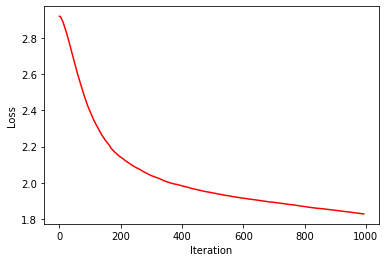




Training acc: 46.5
Testing acc: 48.1


In [97]:
n_hidden = 128
net_lstm = LSTM_net(n_letters, n_hidden, n_languages)
training_setup(net_lstm, 256, 1000, lr=0.005)

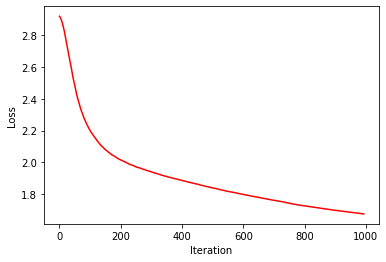




Training acc: 56.00000000000001
Testing acc: 58.3


In [98]:
n_hidden = 128
net_lstm = LSTM_net(n_letters, n_hidden, n_languages)
training_setup(net_lstm, 256, 1000, lr=0.01)

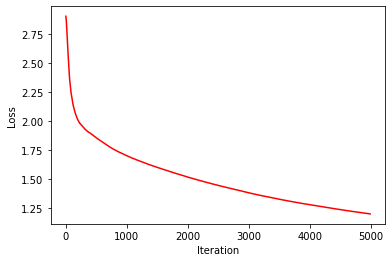




Training acc: 75.8
Testing acc: 74.5


In [99]:
n_hidden = 128
net_lstm = LSTM_net(n_letters, n_hidden, n_languages)
training_setup(net_lstm, 256, 5000, lr=0.01)

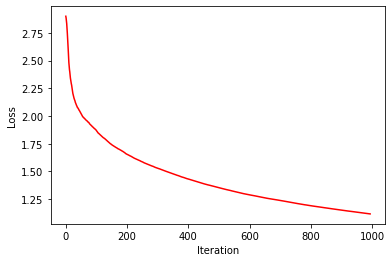




Training acc: 76.9
Testing acc: 76.6


In [100]:
n_hidden = 128
net_lstm = LSTM_net(n_letters, n_hidden, n_languages)
training_setup(net_lstm, 256, 1000, lr=0.1)